In [11]:
# Import libraries
import os
import sys

import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Check virtual environment: should be: '/Users/James/anaconda3/envs/mimic/bin/python'
sys.executable

'/Users/James/anaconda3/envs/mimic/bin/python'

In [3]:
# Set up paths
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
src_folder = os.path.join(project_root, 'src')

In [4]:
# Import src functions
sys.path.insert(0, src_folder)
from modeling import *
from stats_and_visualisations import *
from s3_storage import *

In [5]:
### ---- PARAMETERS
iterations_per_model = 40

In [6]:
# Import data
train = from_s3(bucket='mimic-jamesi',
               filename='acute_kidney_failure_train.csv',
               index_col=0)
print('--> Importing done')

--> Importing done


In [7]:
X_train, y_train, feature_names = final_cleaning(ids = ['subject_id', 'hadm_id'], target = 'target', train = train)
print('--> Cleaning done')

--> Cleaning done


## Logistic regression

In [8]:
# Create temporary training and validation sets
X_train_tmp, X_val_tmp, y_train_tmp, y_val_tmp = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:
# Define training function
def train_logistic(X_train, X_test, y_train, y_test):

    clf = LogisticRegression(random_state=0,
                             solver='lbfgs',
                             class_weight='balanced').fit(X_train, y_train)

    train_predict = clf.predict_proba(X_train)
    test_predict = clf.predict_proba(X_test)

    train_score = roc_auc_score(y_train, train_predict[:,1])
    test_score = roc_auc_score(y_test, test_predict[:,1])

    print('Logistic Train', train_score)
    print('Logistic Test', test_score)
    
    return train_score, test_score

In [10]:
train_logistic(X_train_tmp, X_val_tmp, y_train_tmp, y_val_tmp)

Logistic Train 0.8389259177851668
Logistic Test 0.8368613497737261


(0.8389259177851668, 0.8368613497737261)

## Define functions

In [15]:
def run_random_search(model, random_grid, scoring, cv, n_iter, X_train, y_train):
    
    # Use the random grid to search for best hyperparameters
    m = model
    print('--> Model defined')

    random_search_model = RandomizedSearchCV(estimator = m, scoring=scoring,
                                   param_distributions = random_grid,
                                   n_iter = n_iter, cv = cv, verbose=0,
                                   random_state=8, n_jobs = -1,
                                   return_train_score=True)
    print('--> Random search defined')

    # Fit the random search model
    random_search_model.fit(X_train, y_train)
    print('--> Fitting done')

    # Print the best CV score
    print('--> Best CV Score: ', random_search_model.best_score_)
    
    return random_search_model

In [16]:
def visualise_results(random_grid, random_search_model, training_score, cv_score, fit_time):
    
    # Clean the CV results df, keeping only columns that are needed
    keep_cols = ['param_{}'.format(param) for param in random_grid.keys()]
    keep_cols = keep_cols + [training_score, cv_score, fit_time]
    results = pd.DataFrame(random_search_model.cv_results_)[keep_cols]

    # Visualise best CV score by run
    best_cv_by_run(results, cv_score)

    # Visualise the scores by single hyperparameters
    plot_single_results(results, training_score, cv_score, fit_time)

    # Visualise the scores by double hyperparameters
    plot_double_results(results, [training_score, cv_score, fit_time])

    results.sort_values(by=cv_score, ascending=False, inplace=True)
    
    return results

## Decision tree

In [18]:
# define the grid search parameters
criterion = ['gini', 'entropy']
class_weight = ['balanced']
max_features = list(np.arange(2, X_train.shape[1]))
max_depth = list(np.arange(1, 100))
max_depth.append(None)
min_samples_split = list(np.arange(2, 250))
min_samples_leaf = list(np.arange(1, 250))

# Create the random grid
dt_random_grid = {'criterion': criterion,
                  'class_weight': class_weight,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

print('--> Grid defined')

--> Grid defined


In [19]:
# Run the random search model
dt_random_search_model = run_random_search(model=DecisionTreeClassifier(), random_grid=dt_random_grid,
                                        scoring='roc_auc', cv=5, n_iter=iterations_per_model, 
                                        X_train=X_train, y_train=y_train)

--> Model defined
--> Random search defined
--> Fitting done
--> Best CV Score:  0.8494302747577338


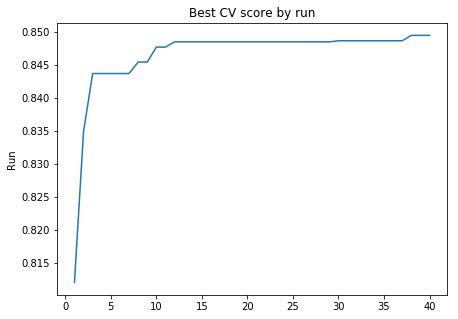

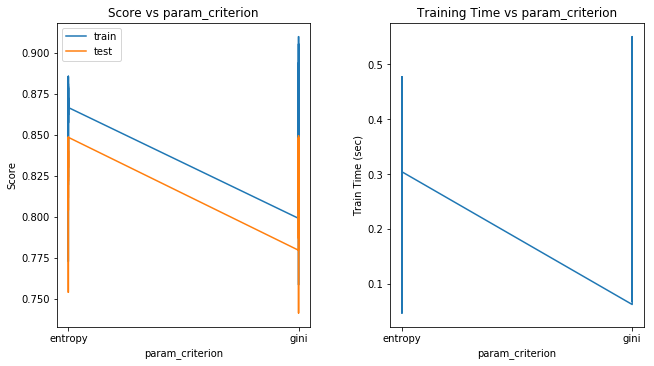

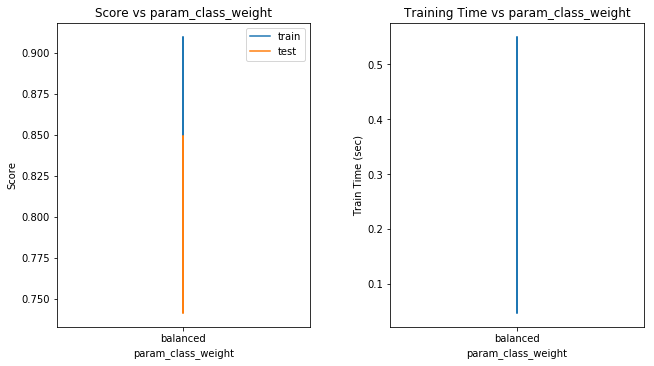

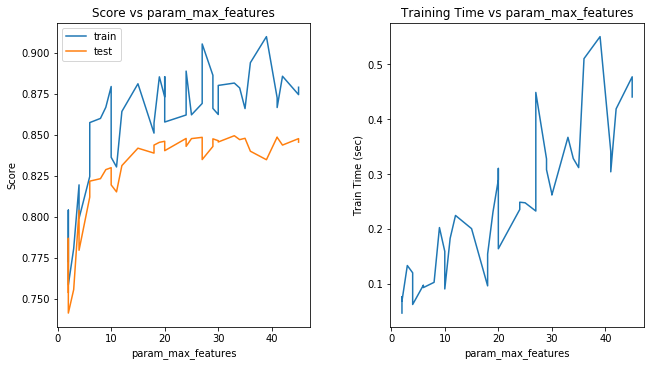

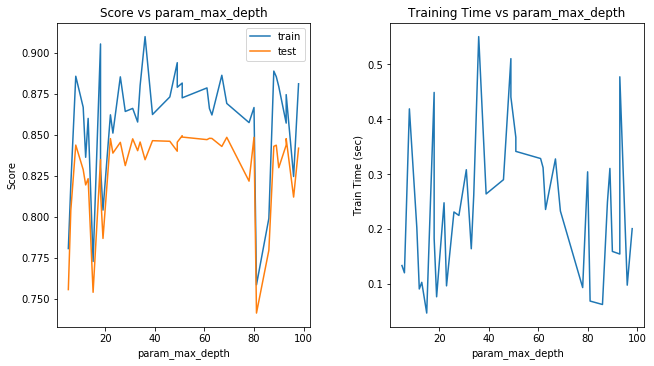

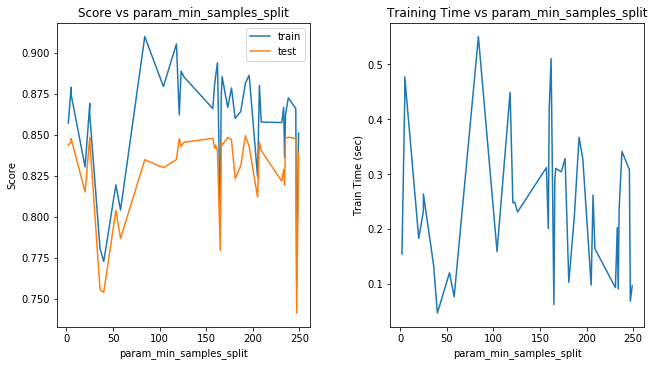

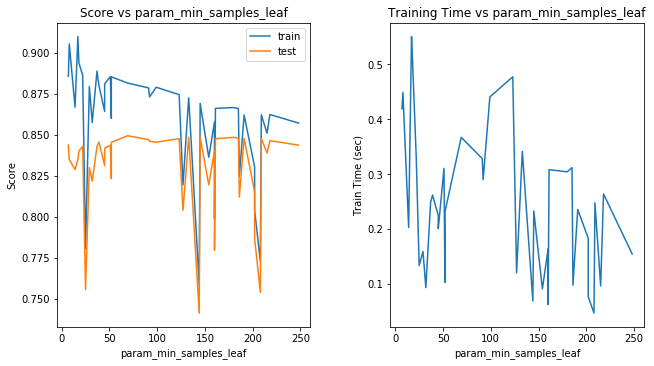

param_criterion and param_class_weight


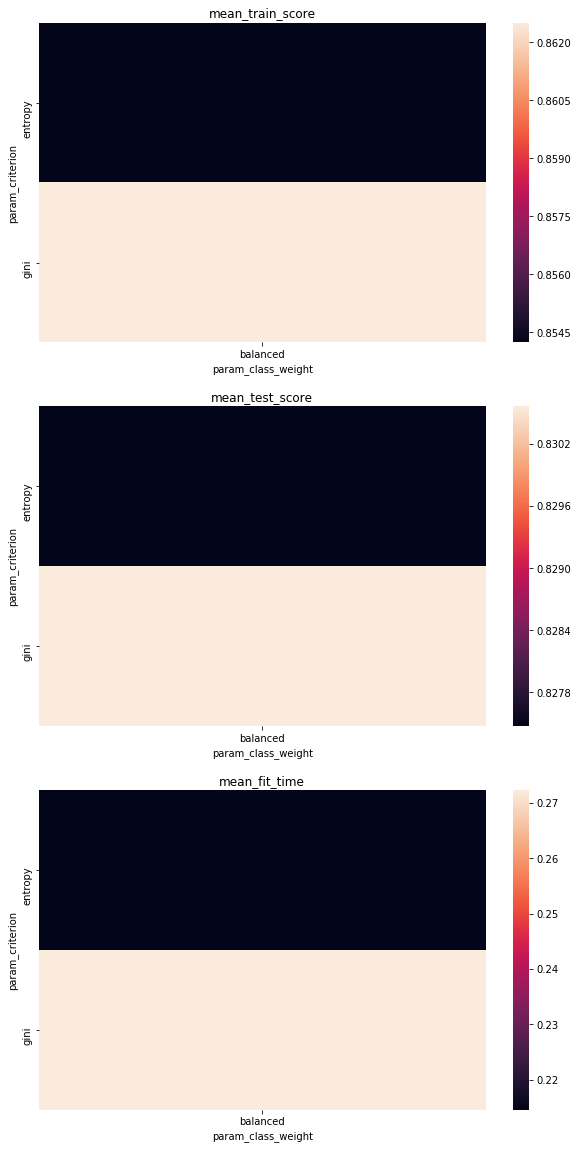


param_criterion and param_max_features


<Figure size 432x288 with 0 Axes>

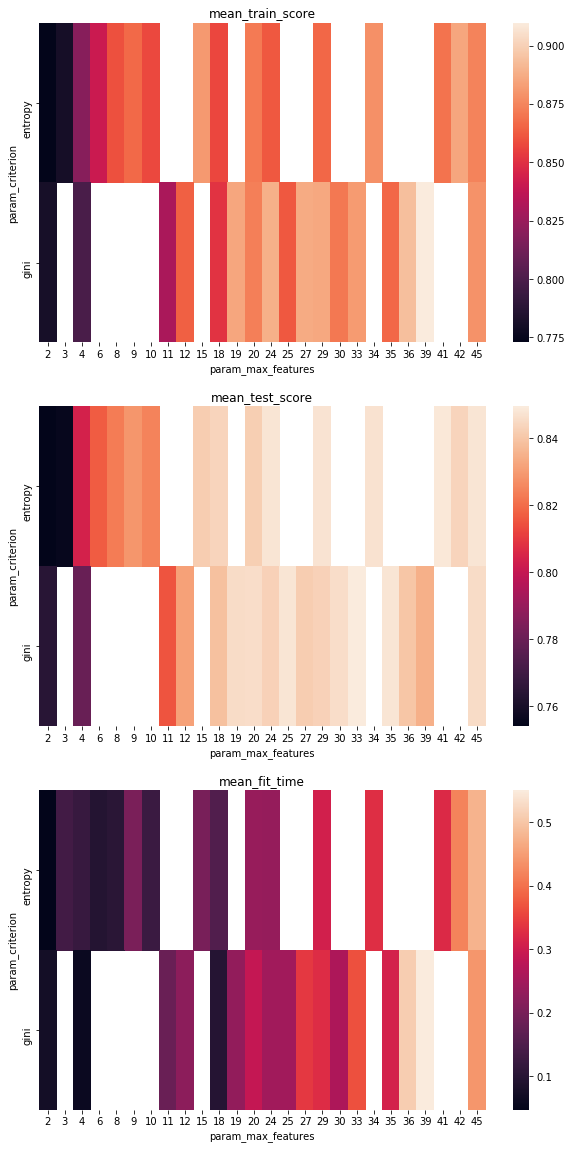


param_criterion and param_max_depth


<Figure size 432x288 with 0 Axes>

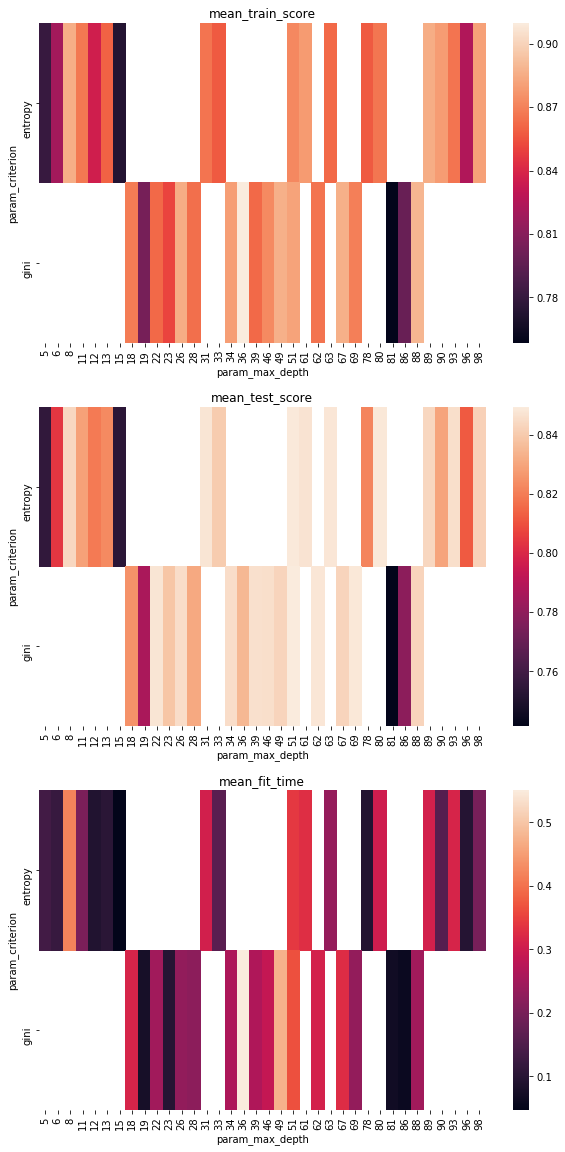


param_criterion and param_min_samples_split


<Figure size 432x288 with 0 Axes>

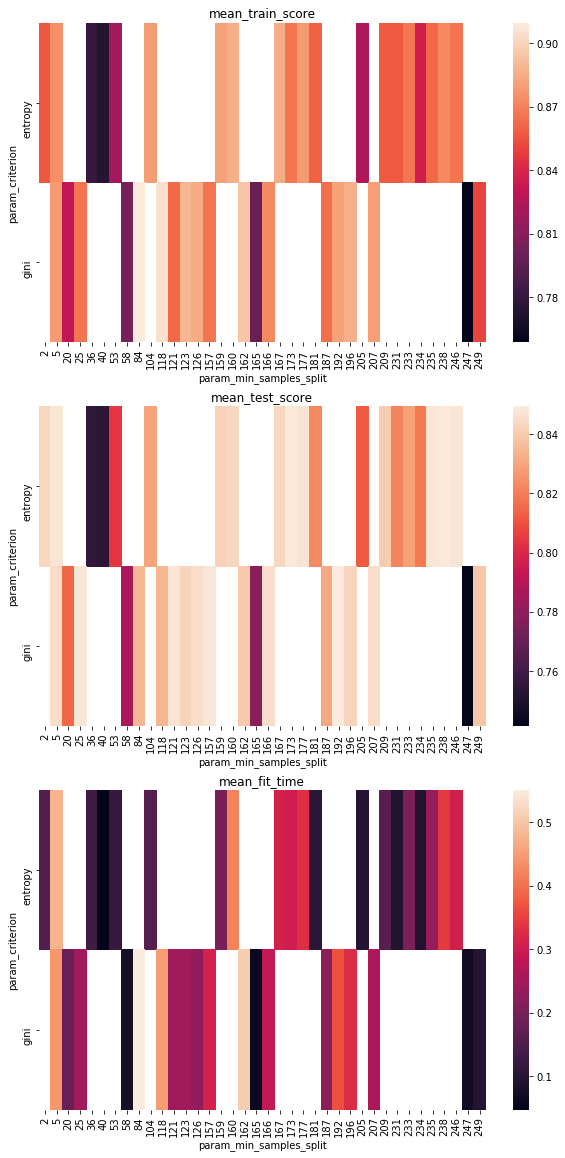


param_criterion and param_min_samples_leaf


<Figure size 432x288 with 0 Axes>

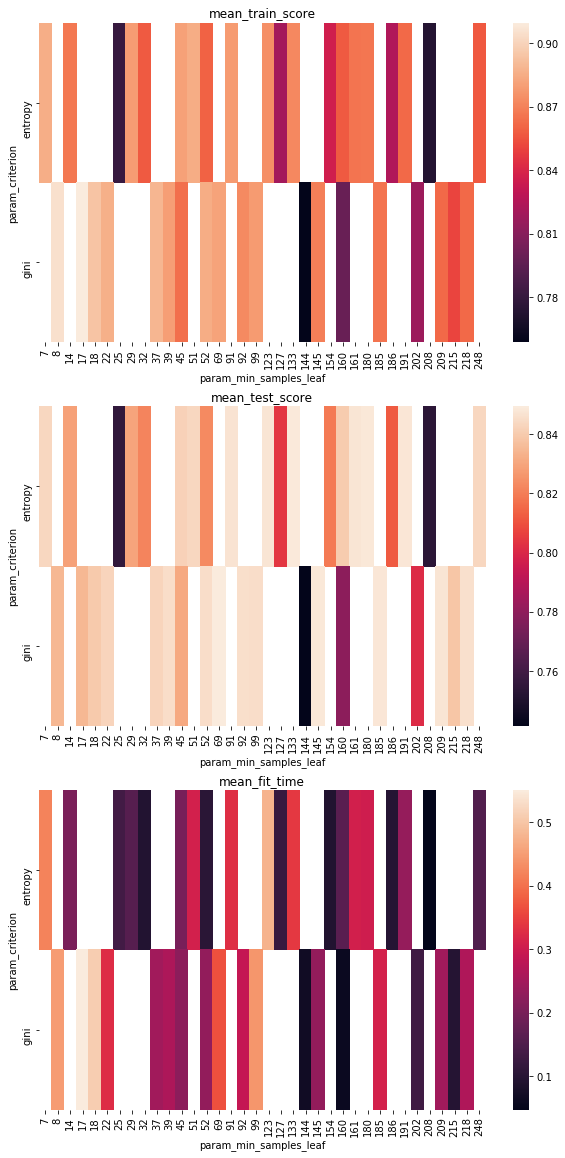


param_class_weight and param_max_features


<Figure size 432x288 with 0 Axes>

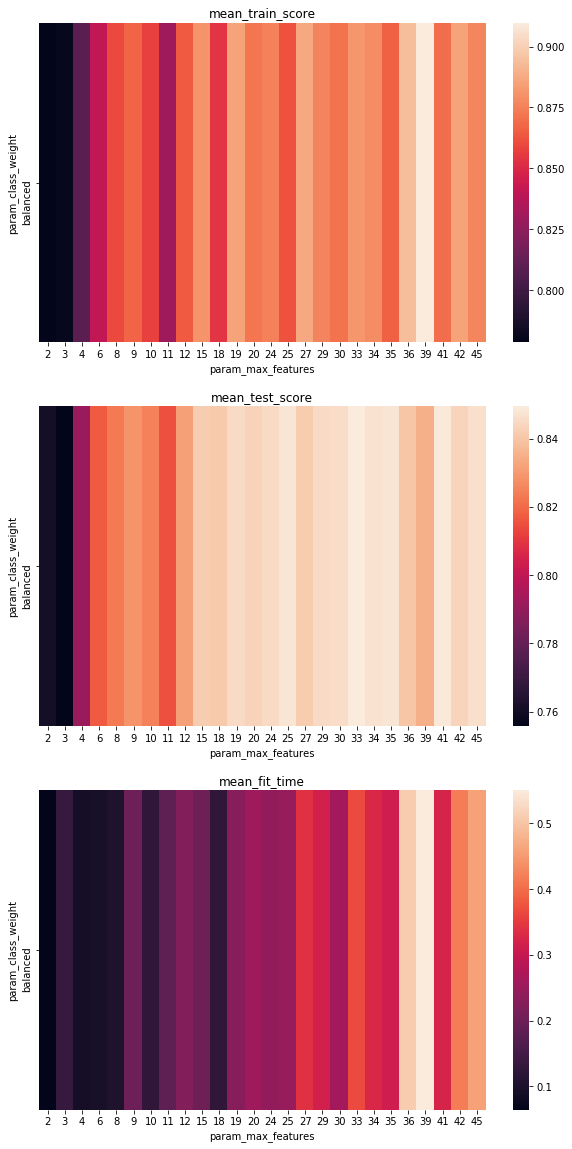


param_class_weight and param_max_depth


<Figure size 432x288 with 0 Axes>

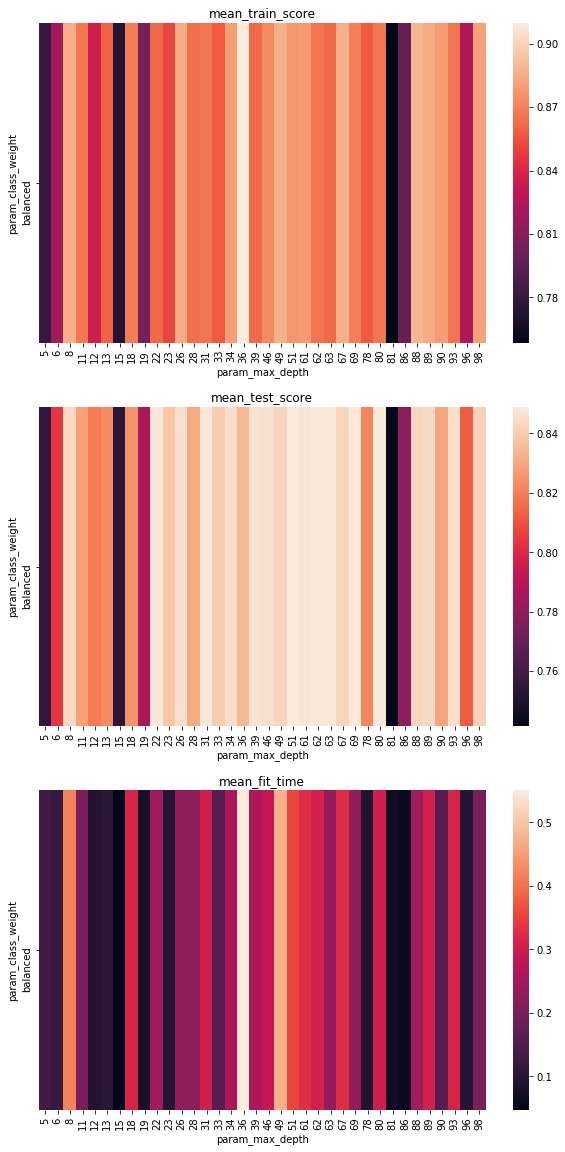


param_class_weight and param_min_samples_split


<Figure size 432x288 with 0 Axes>

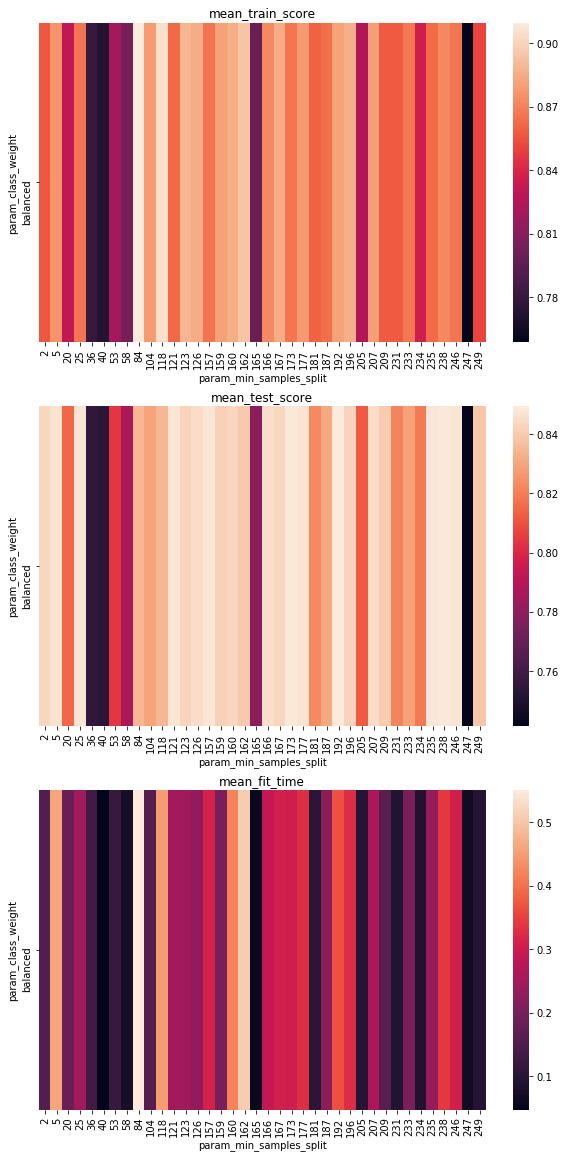


param_class_weight and param_min_samples_leaf


<Figure size 432x288 with 0 Axes>

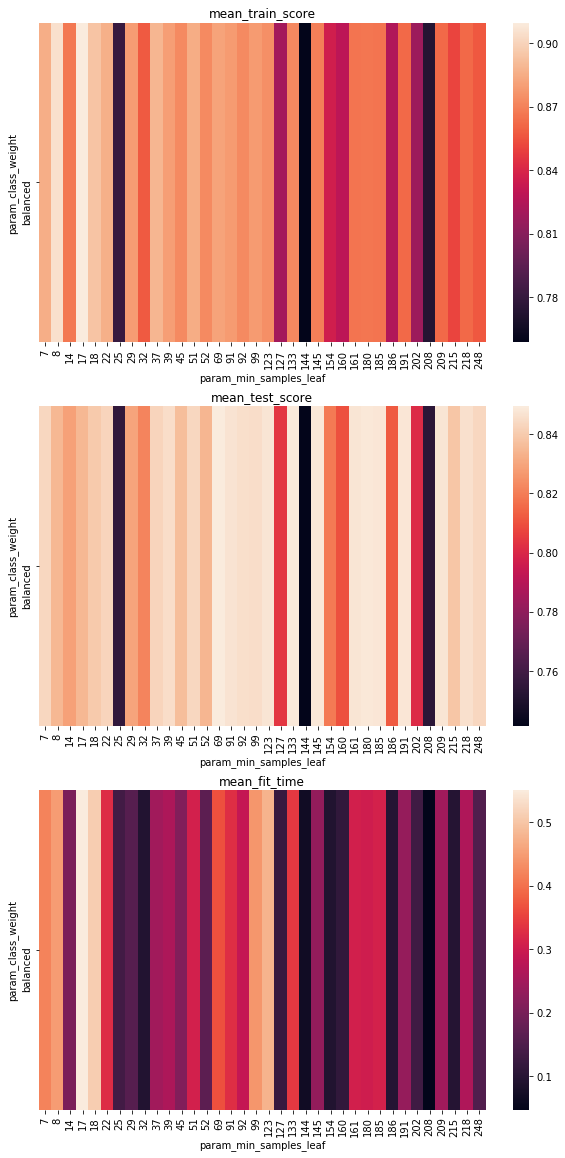


param_max_features and param_max_depth


<Figure size 432x288 with 0 Axes>

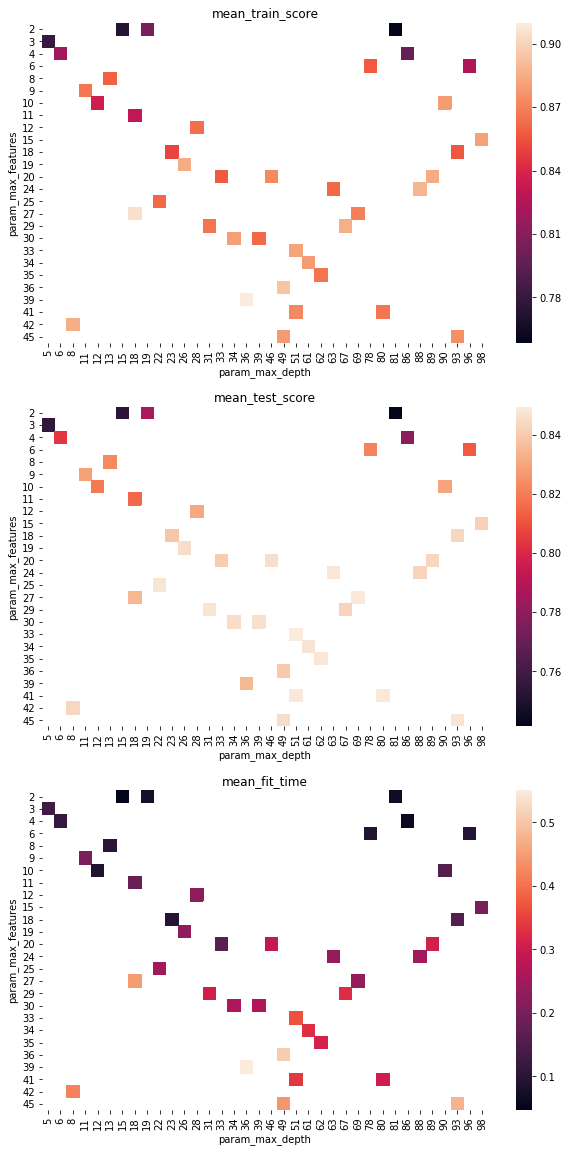


param_max_features and param_min_samples_split


<Figure size 432x288 with 0 Axes>

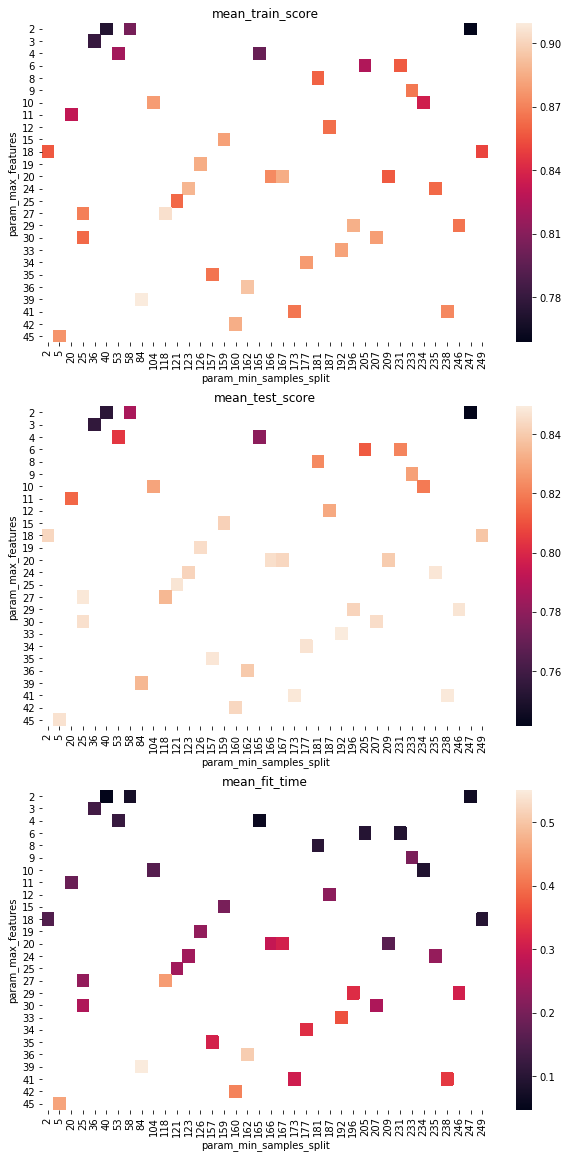


param_max_features and param_min_samples_leaf


<Figure size 432x288 with 0 Axes>

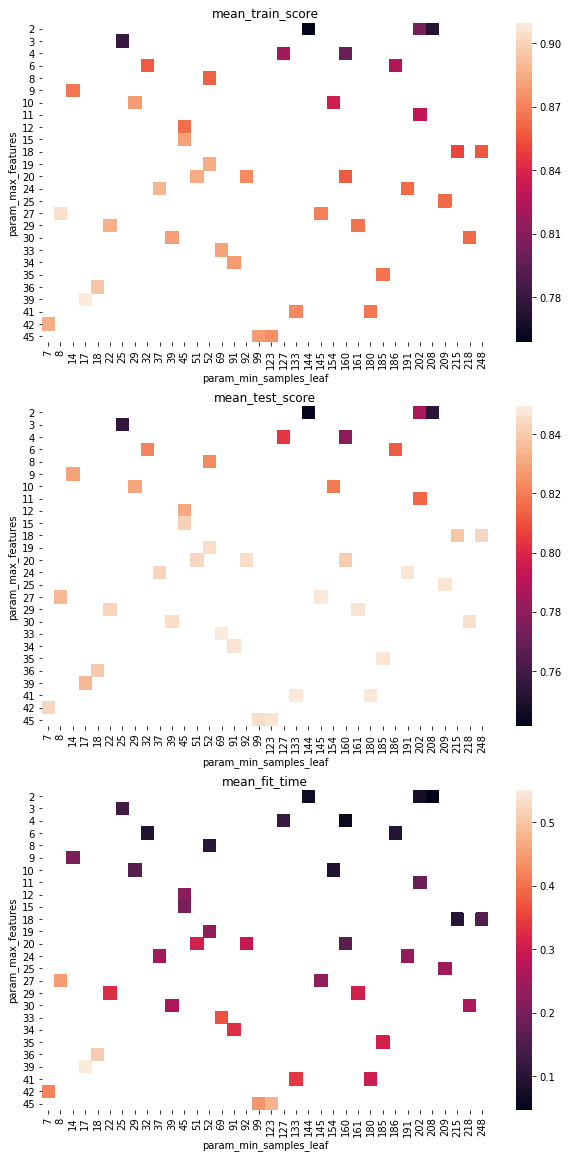


param_max_depth and param_min_samples_split


<Figure size 432x288 with 0 Axes>

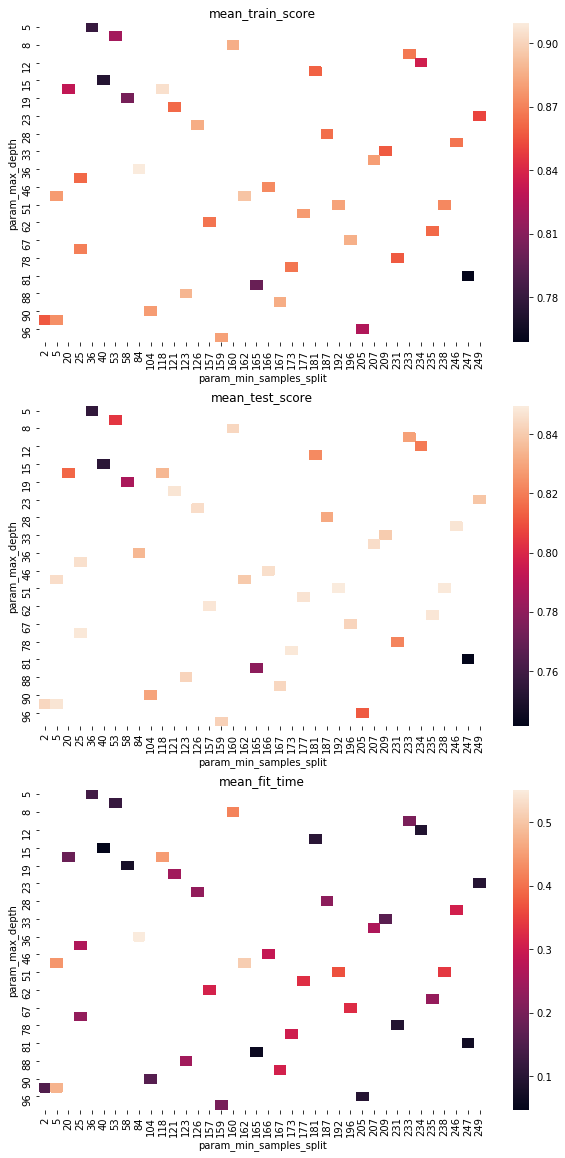


param_max_depth and param_min_samples_leaf


<Figure size 432x288 with 0 Axes>

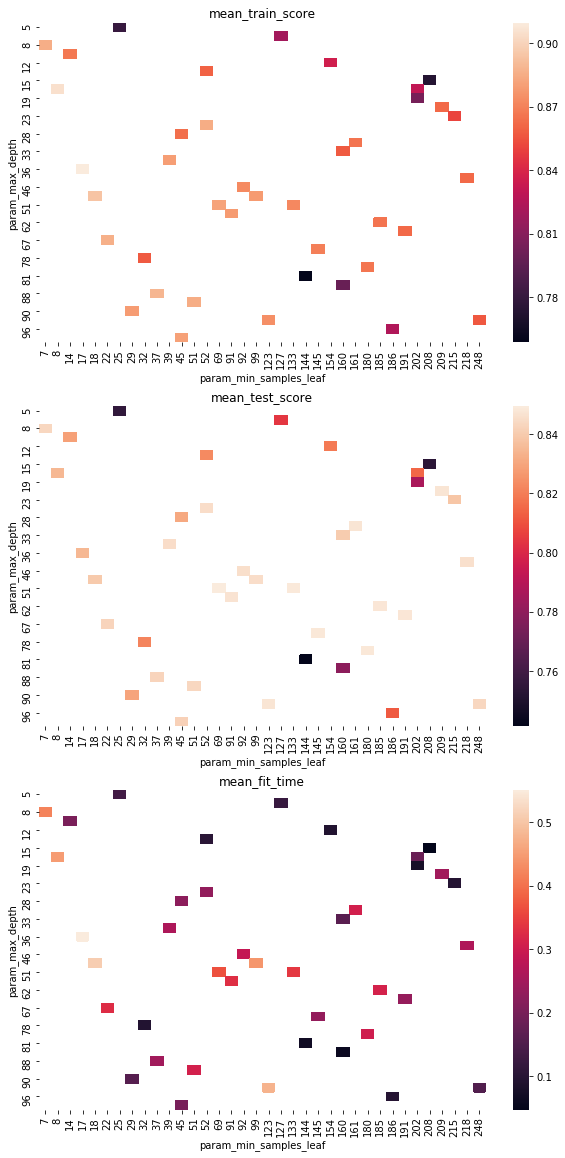


param_min_samples_split and param_min_samples_leaf


<Figure size 432x288 with 0 Axes>

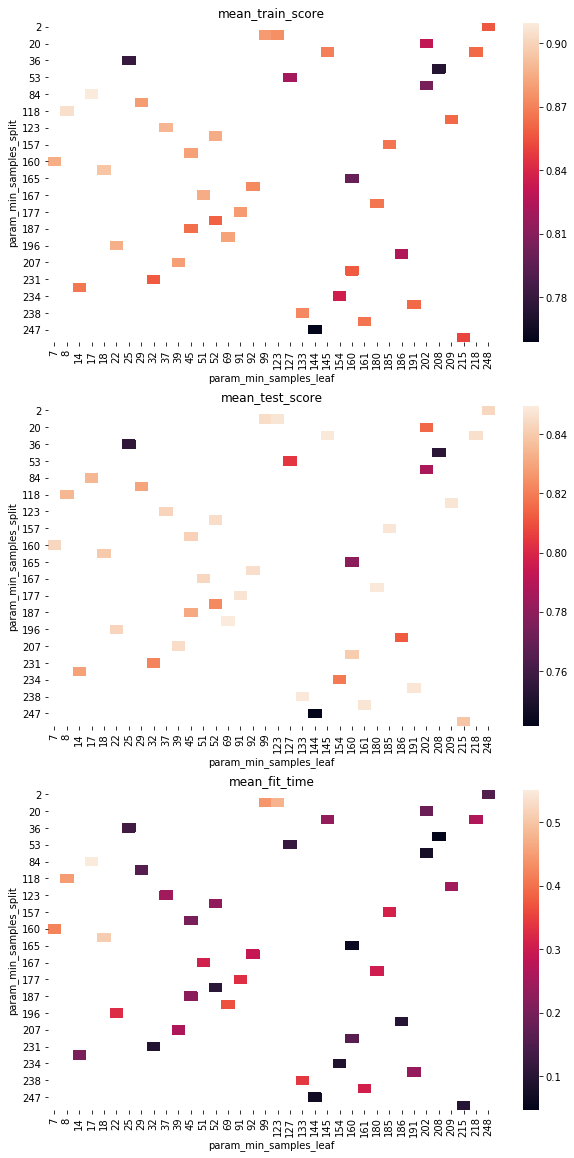

,param_criterion,param_class_weight,param_max_features,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_train_score,mean_test_score,mean_fit_time
37,gini,balanced,33,51,192,69,0.881504,0.849430,0.367024
29,entropy,balanced,41,51,238,133,0.872505,0.848614,0.341394
39,entropy,balanced,41,80,173,180,0.866603,0.848449,0.304188
11,gini,balanced,27,69,25,145,0.869092,0.848447,0.232791
17,gini,balanced,35,62,157,185,0.865970,0.847864,0.311851
16,entropy,balanced,24,63,235,191,0.862062,0.847771,0.235618
28,gini,balanced,25,22,121,209,0.862155,0.847674,0.247814
9,entropy,balanced,45,93,5,123,0.874460,0.847655,0.477195
32,entropy,balanced,29,31,246,161,0.866070,0.847534,0.308014
33,entropy,balanced,34,61,177,91,0.878544,0.847051,0.328387


<Figure size 432x288 with 0 Axes>

In [20]:
# Visualise the results to find optimal hyperparameters
dt_results = visualise_results(random_grid=dt_random_grid, random_search_model=dt_random_search_model,
                            training_score='mean_train_score', cv_score='mean_test_score', fit_time='mean_fit_time')
dt_results

## Random Forest

In [ ]:
# define the grid search parameters
n_estimators = list(np.arange(20, 3000, 5))
max_features = list(np.arange(2, X_train.shape[1]))
max_depth = list(np.arange(1, 100))
max_depth.append(None)
min_samples_split = list(np.arange(2, 250))
min_samples_leaf = list(np.arange(1, 250))
bootstrap = [True, False]

# Create the random grid
rf_random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

print('--> Grid defined')

In [ ]:
# Run the random search model
rf_random_search_model = run_random_search(model=RandomForestRegressor(), random_grid=rf_random_grid,
                                        scoring='roc_auc', cv=5, n_iter=iterations_per_model, 
                                        X_train=X_train, y_train=y_train)

In [ ]:
# Visualise the results to find optimal hyperparameters
rf_results = visualise_results(random_grid=rf_random_grid, random_search_model=rf_random_search_model,
                            training_score='mean_train_score', cv_score='mean_test_score', fit_time='mean_fit_time')
rf_results